In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.preprocessing.image import load_img 
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D,Input

In [3]:
BASE_DIR="archive/UTKFace"

In [4]:
image_paths=[]
age_labels=[]
gender_labels=[]

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path=os.path.join(BASE_DIR,filename)
    temp=filename.split('_')
    age=int(temp[0])
    gender=int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/1035 [00:00<?, ?it/s]

In [5]:
df=pd.DataFrame()
df['image'],df['age'],df['gender']=image_paths,age_labels,gender_labels
df.head()

image  age  gender
0  archive/UTKFace\100_0_0_20170112213500903.jpg....  100       0
1  archive/UTKFace\100_0_0_20170112215240346.jpg....  100       0
2  archive/UTKFace\100_1_0_20170110183726390.jpg....  100       1
3  archive/UTKFace\100_1_0_20170112213001988.jpg....  100       1
4  archive/UTKFace\100_1_0_20170112213303693.jpg....  100       1

In [6]:
gender_dict={0:'Male',1:'Female'}

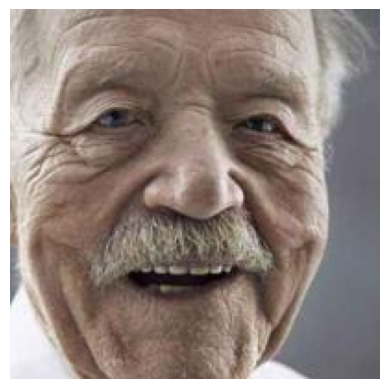

In [7]:
from PIL import Image
img=Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

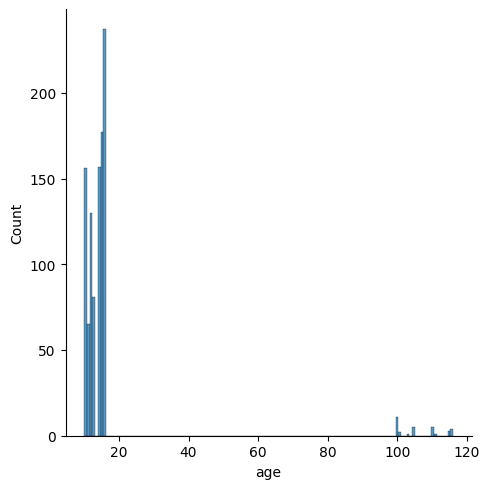

In [11]:
sns.displot(df['age'])

<Axes: ylabel='count'>

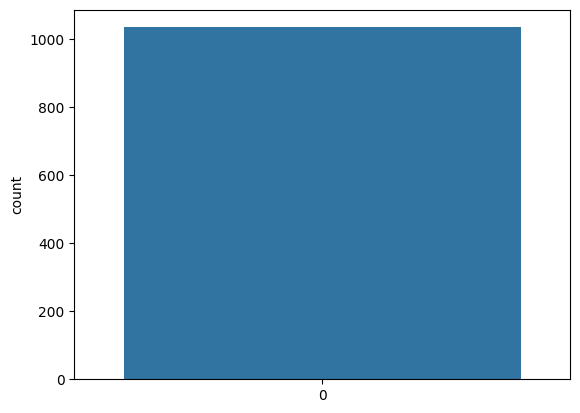

In [9]:
sns.countplot(df['gender'])

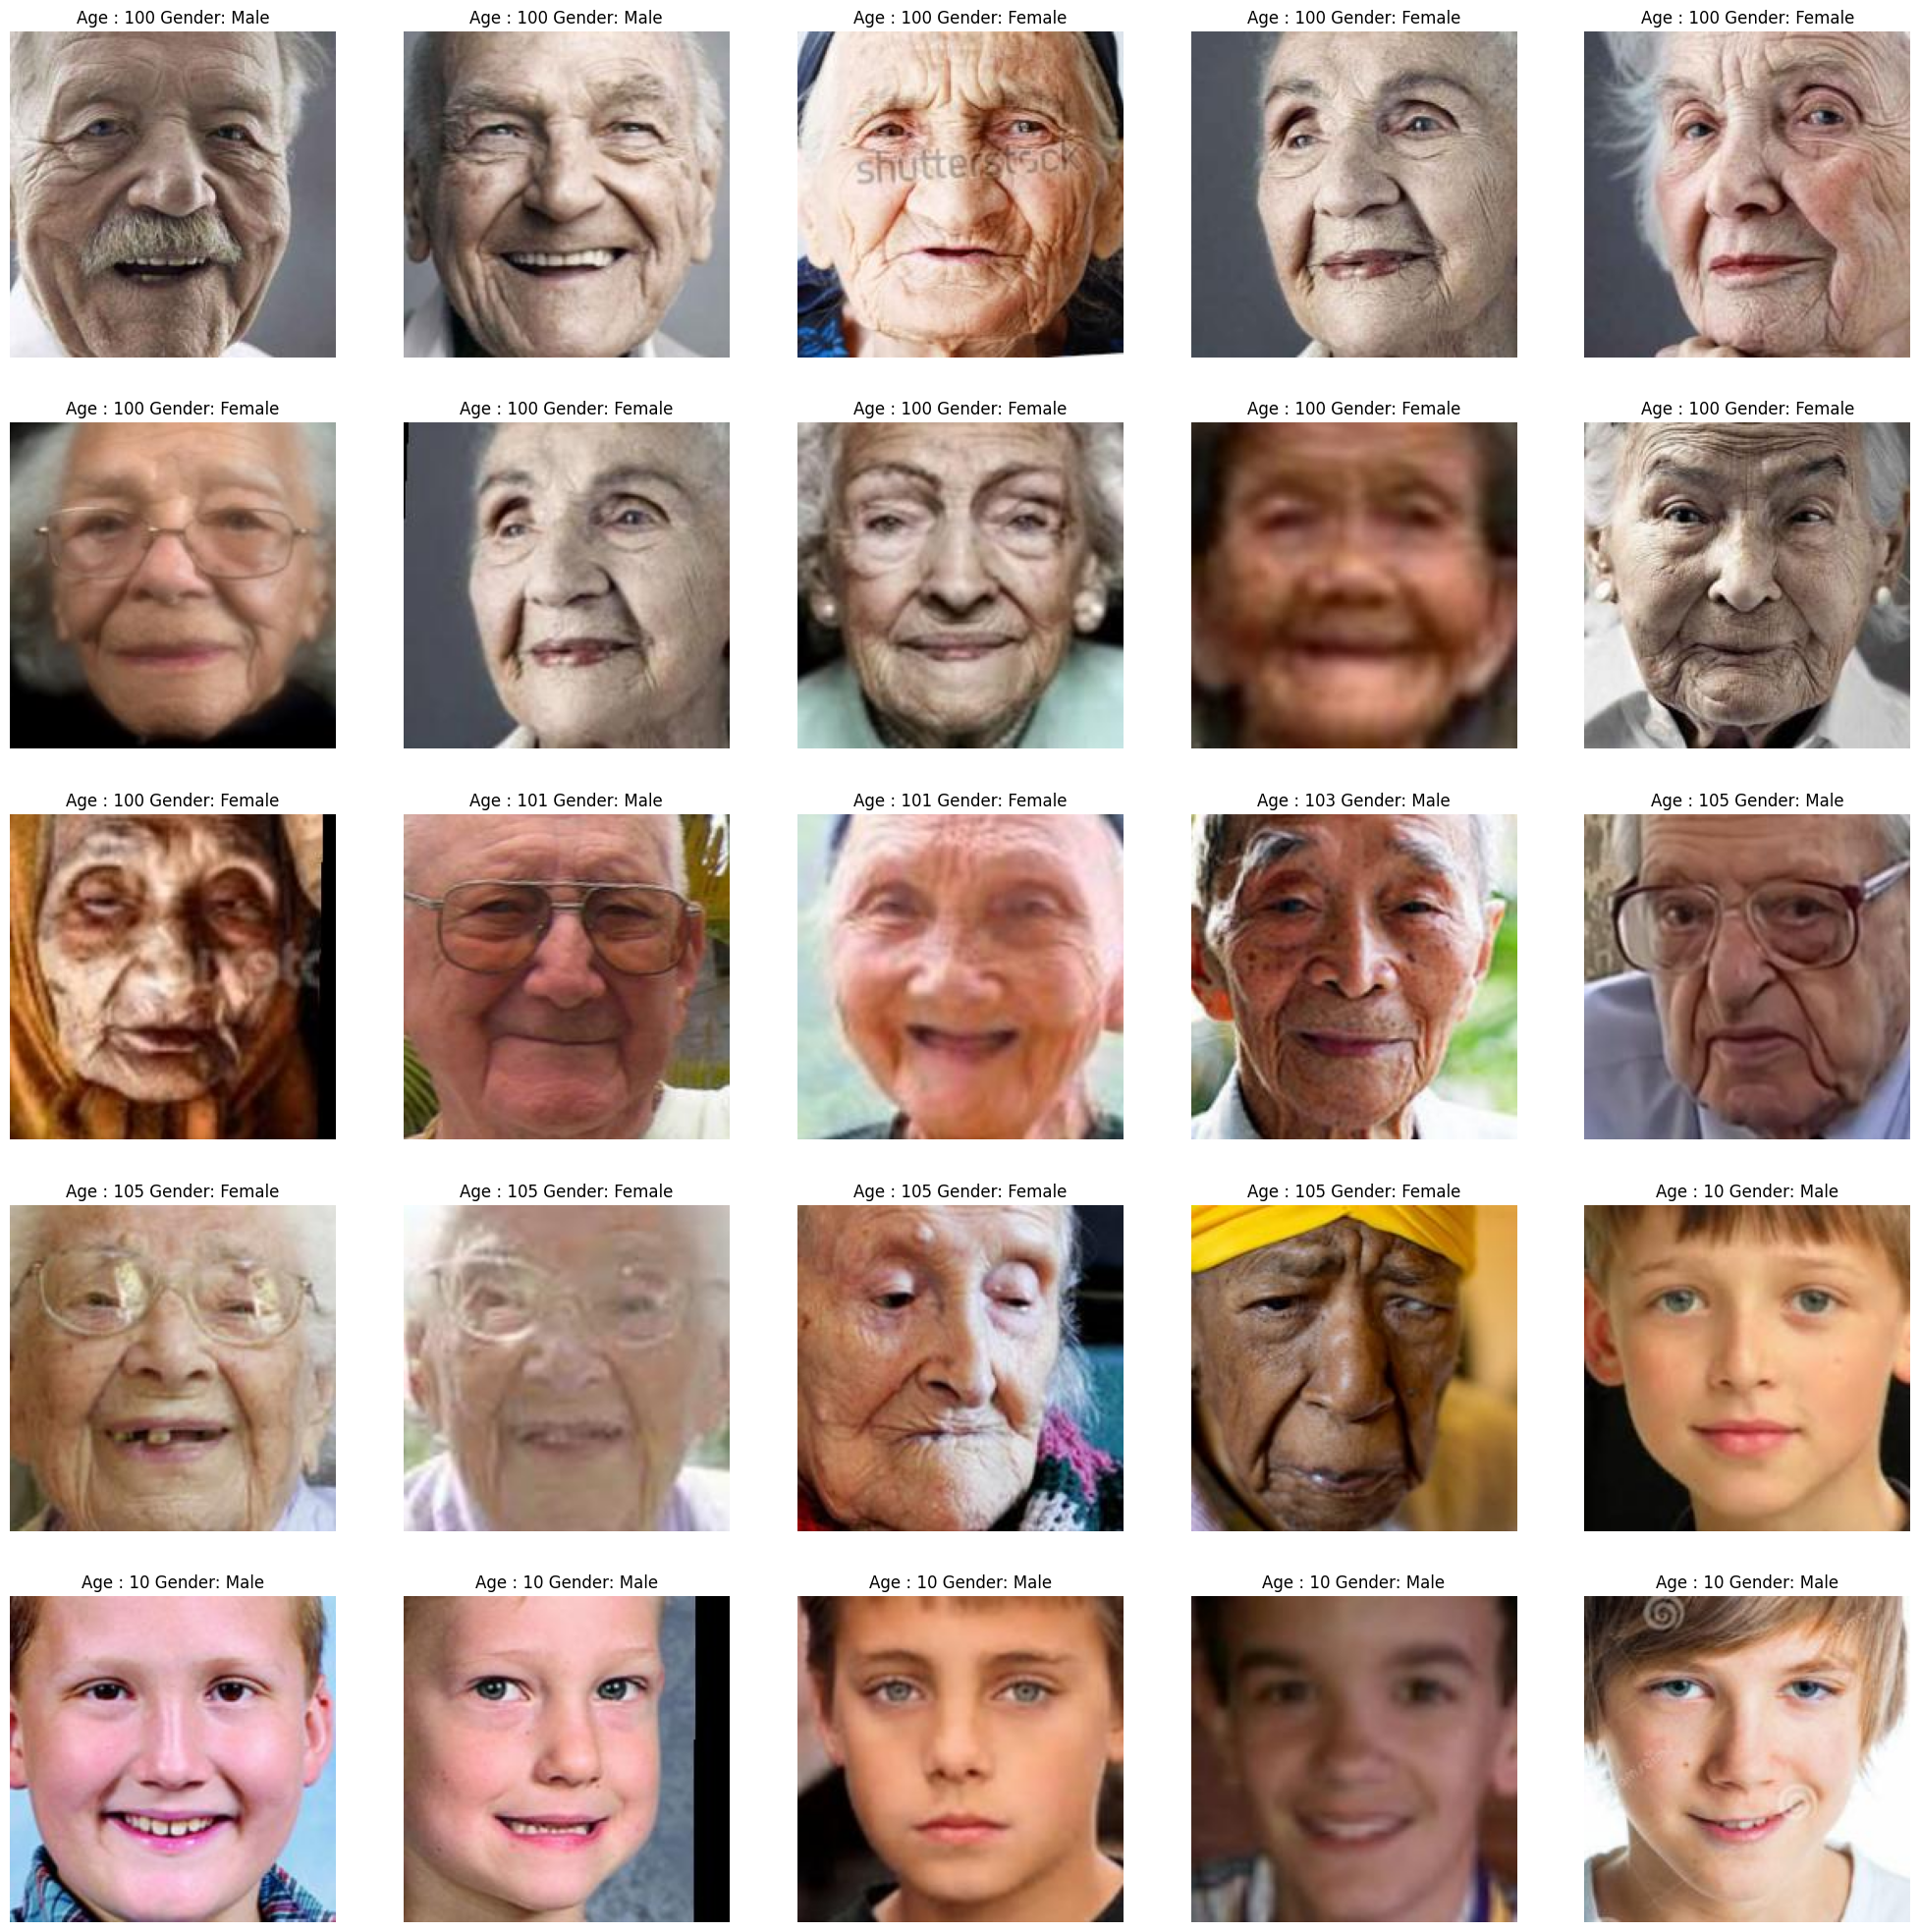

In [13]:
plt.figure(figsize=(25,25))
files=df.iloc[0:25]

for index,file,age,gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img=load_img(file)
    img=np.array(img)
    plt.imshow(img)
    plt.title(f'Age : {age} Gender: {gender_dict[gender]}')
    plt.axis('off')

In [15]:
## feature extraction

def extract_features(images):
    features=[]
    for image in tqdm(images):
        img=load_img(image,grayscale=True)
        img=img.resize((128,128), Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
        
    features=np.array(features)
    features=features.reshape(len(features),128,128,1)
    return features

In [16]:
X=extract_features(df['image'])

  0%|          | 0/1035 [00:00<?, ?it/s]

In [17]:
X.shape

(1035, 128, 128, 1)

In [18]:
X=X/255.0

In [19]:
y_gender=np.array(df['gender'])
y_age=np.array(df['age'])

In [20]:
input_shape=(128,128,1)

In [25]:
inputs=Input((input_shape))
conv_1=Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
maxp_1=MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2=Conv2D(64,kernel_size=(3,3),activation='relu')(maxp_1)
maxp_2=MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3=Conv2D(128,kernel_size=(3,3),activation='relu')(maxp_2)
maxp_3=MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4=Conv2D(256,kernel_size=(3,3),activation='relu')(maxp_3)
maxp_4=MaxPooling2D(pool_size=(2,2))(conv_4)

flatten=Flatten() (maxp_4)

dense_1=Dense(256,activation='relu')(flatten)
dense_2=Dense(256,activation='relu')(flatten)

dropout_1=Dropout(0.3) (dense_1)
dropout_2=Dropout(0.3)(dense_2)

output_1=Dense(1,activation='sigmoid' , name='gender_out')(dropout_1)
output_2=Dense(1,activation='relu' , name='age_out')(dropout_2)

model=Model(inputs=[inputs],outputs=[output_1,output_2])

model.compile(loss=['binary_crossentropy','mae'],optimizer='adam',metrics=['accuracy'])

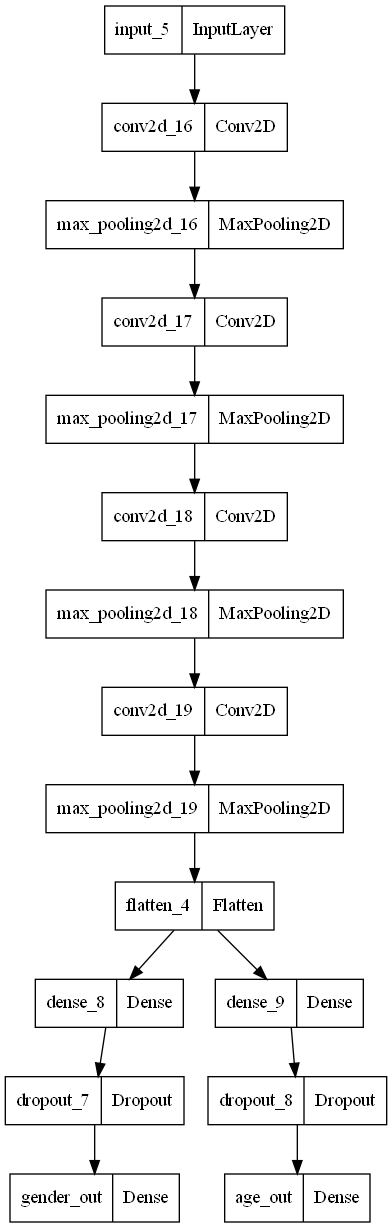

In [27]:
from keras.utils import plot_model
plot_model(model)

In [28]:
history=model.fit(x=X,y=[y_gender,y_age],batch_size=32,epochs=30,validation_split=0.2)

Epoch 1/30
26/26 [==============================] - 18s 583ms/step - loss: 8.3992 - gender_out_loss: 0.8234 - age_out_loss: 7.5758 - gender_out_accuracy: 0.4698 - age_out_accuracy: 0.0000e+00 - val_loss: 5.2227 - val_gender_out_loss: 0.6989 - val_age_out_loss: 4.5239 - val_gender_out_accuracy: 0.4976 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
26/26 [==============================] - 18s 696ms/step - loss: 6.5671 - gender_out_loss: 0.6993 - age_out_loss: 5.8678 - gender_out_accuracy: 0.4928 - age_out_accuracy: 0.0000e+00 - val_loss: 4.6528 - val_gender_out_loss: 0.6944 - val_age_out_loss: 3.9584 - val_gender_out_accuracy: 0.5024 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
26/26 [==============================] - 17s 638ms/step - loss: 6.4144 - gender_out_loss: 0.6942 - age_out_loss: 5.7202 - gender_out_accuracy: 0.5229 - age_out_accuracy: 0.0000e+00 - val_loss: 5.7099 - val_gender_out_loss: 0.6934 - val_age_out_loss: 5.0165 - val_gender_out_accuracy: 0.5024 - val_age_out_accuracy: 

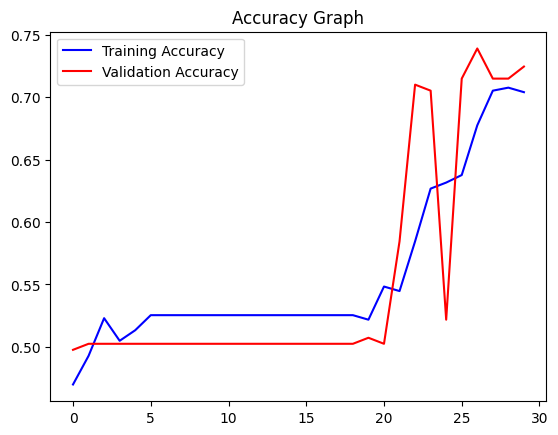

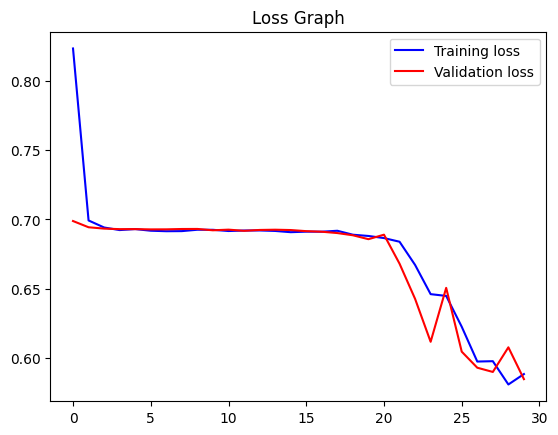

In [29]:
acc=history.history['gender_out_accuracy']
val_acc=history.history['val_gender_out_accuracy']
epochs=range(len(acc))

plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss=history.history['gender_out_loss']
val_loss=history.history['val_gender_out_loss']

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

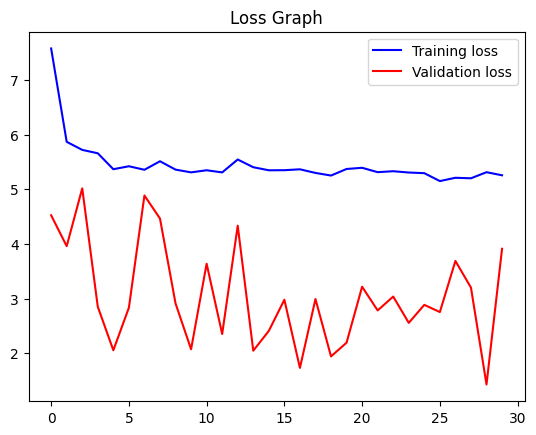

In [30]:
loss=history.history['age_out_loss']
val_loss=history.history['val_age_out_loss']
epochs=range(len(acc))

plt.plot(epochs,loss,'b',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 10
1/1 [==============================] - 0s 88ms/step
Predicted Gender: Male Predicted Age: 12


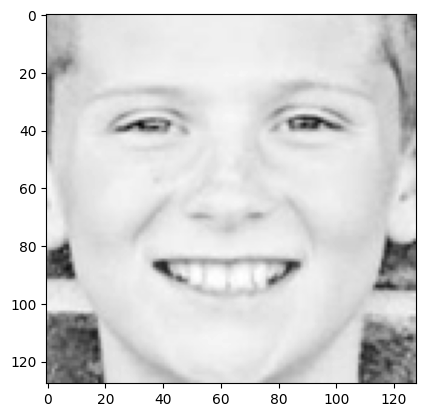

In [36]:
image_index=40
print("Original Gender:",gender_dict[y_gender[image_index]], "Original Age:",y_age[image_index])
pred=model.predict(X[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128,128),cmap='gray');

Original Gender: Female Original Age: 16
1/1 [==============================] - 0s 72ms/step
Predicted Gender: Female Predicted Age: 12


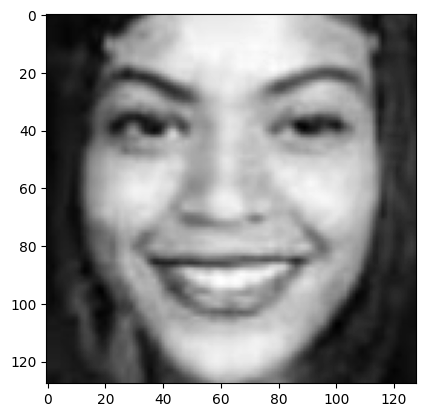

In [37]:
image_index=1000
print("Original Gender:",gender_dict[y_gender[image_index]], "Original Age:",y_age[image_index])
pred=model.predict(X[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128,128),cmap='gray');

Original Gender: Male Original Age: 10
1/1 [==============================] - 0s 68ms/step
Predicted Gender: Male Predicted Age: 12


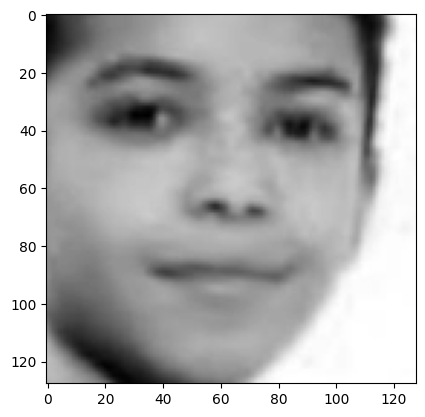

In [38]:
image_index=89
print("Original Gender:",gender_dict[y_gender[image_index]], "Original Age:",y_age[image_index])
pred=model.predict(X[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128,128),cmap='gray');

Original Gender: Female Original Age: 16
1/1 [==============================] - 0s 72ms/step
Predicted Gender: Female Predicted Age: 14


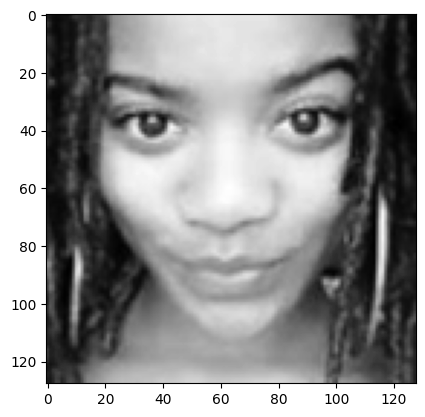

In [41]:
image_index=1010
print("Original Gender:",gender_dict[y_gender[image_index]], "Original Age:",y_age[image_index])
pred=model.predict(X[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128,128),cmap='gray');

Original Gender: Male Original Age: 14
1/1 [==============================] - 0s 71ms/step
Predicted Gender: Male Predicted Age: 12


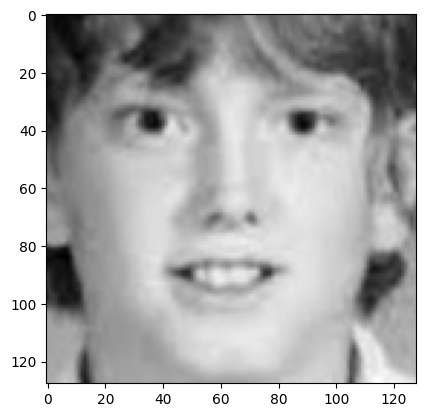

In [42]:
image_index=500
print("Original Gender:",gender_dict[y_gender[image_index]], "Original Age:",y_age[image_index])
pred=model.predict(X[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128,128),cmap='gray');

Original Gender: Male Original Age: 11
1/1 [==============================] - 0s 79ms/step
Predicted Gender: Female Predicted Age: 12


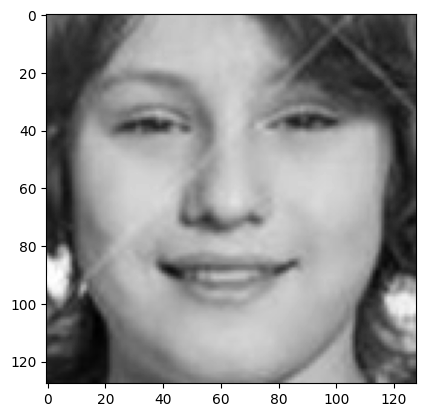

In [43]:
image_index=200
print("Original Gender:",gender_dict[y_gender[image_index]], "Original Age:",y_age[image_index])
pred=model.predict(X[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("Predicted Gender:",pred_gender,"Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128,128),cmap='gray');